In [1]:
import math
import random
import numpy as np
import pandas as pd
import networkx as nx
import scipy as sc
from tqdm import tqdm

from matplotlib import pyplot as plt
from signet.cluster import Cluster
from sklearn.model_selection import train_test_split
#from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [2]:
# for google colab
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# reading the raw dataset which may contain duplicates, node ids out of range (id of nodes should be assigned from zero to number_of_nodes - 1)
#df_raw = pd.read_csv("Datasets/New_ Microsoft_ Excel_ Worksheet.csv")
df_raw = pd.read_csv("Datasets/soc-sign-epinions_modified.csv")

In [4]:
df_raw

,source,target,sign
0,1,2,-1
1,130144,2,1
2,5080,3,1
3,3,4,1
4,117,4,1
...,...,...,...
841367,92808,131814,-1
841368,131816,131817,1
841369,131819,131820,-1
841370,131824,131825,1


In [5]:
df_no_dup = df_raw.drop_duplicates(inplace = False)
df_no_dup = df_no_dup.reset_index(drop=True)

In [6]:
df_no_dup

,source,target,sign
0,1,2,-1
1,130144,2,1
2,5080,3,1
3,3,4,1
4,117,4,1
...,...,...,...
841367,92808,131814,-1
841368,131816,131817,1
841369,131819,131820,-1
841370,131824,131825,1


In [7]:
# function to assign new ids to nodes regarding keeping ids in zero to num_of_nodes - 1
def relabel(df):
    source_old_labels = df["source"].drop_duplicates().to_numpy()
    #print(source_old_labels)
    target_old_labels = df["target"].drop_duplicates().to_numpy()
    all_old_labels = np.union1d(source_old_labels, target_old_labels)
    index_map = dict(enumerate(all_old_labels))
    new_index_map = dict([(value, key) for key, value in index_map.items()])
    #print(index_map == new_index_map)
    new_df = df.copy()
    for index, row in new_df.iterrows():
        #print(row["source"])
        row["source"] = new_index_map[row["source"]]
        row["target"] = new_index_map[row["target"]]
    return new_index_map, new_df

In [8]:
ind_map, df_relabled = relabel(df_no_dup)

#### اگر طوقه داشته باشه دیتاست نباید از MultiDiGraph استفاده شود

In [9]:
main_graph = nx.DiGraph()
main_graph = nx.from_pandas_edgelist(df = df_relabled, source = 'source', target = 'target', edge_attr = 'sign', create_using = nx.DiGraph(), edge_key = 'sign')

In [10]:
print('number of nodes G =', nx.number_of_nodes(main_graph) )
print('number of edges G =', nx.number_of_edges(main_graph) )
print('Density of G:', nx.density(main_graph))

number of nodes G = 131828
number of edges G = 841372
Density of G: 4.841456374018419e-05


### توجه شود که اختلاف تعداد یال‎های گراف با سطرهای دیتافریم به دلیل وجود یال چندگانه یا طوقه در دیتا فریم است.

In [11]:
def graphTrainTestSplit(G, df, train_size, positive_size = 0.8):
    G_train = G.copy()
    train_df = df.copy()
    test_df = df.copy()
    edges_no = nx.number_of_edges(G_train)
    test_size = 1 - train_size
    
    # Get the indices of positive and negative labels
    positive_indices = train_df[train_df['sign'] == 1].index.to_list()
    negative_indices = train_df[train_df['sign'] == -1].index.to_list()
    
    # Shuffle the indices randomly
    random.shuffle(positive_indices)
    random.shuffle(negative_indices)
    
    # Calculate the number of positive and negative labels for test set
    negative_size = 1 - positive_size
    test_positive_count = int(test_size * edges_no * positive_size)
    test_negative_count = int(test_size * edges_no * negative_size)
    # test_positive_count = int(train_size * len(positive_indices))
    # test_negative_count = int(train_size * len(negative_indices))
    number_of_edges_left_for_removal = test_positive_count + test_negative_count
    
    edges_to_remove = []  # List to store edges for removal
    
    #print("number_of_edges_left_for_removal: ", number_of_edges_left_for_removal, 'test_positive_count:', test_positive_count, 'test_negative_count: ', test_negative_count)

    while number_of_edges_left_for_removal > 0:
        edges = np.array(G_train.edges)
        chosen_edge = random.choice(edges)
        source = chosen_edge[0]
        target = chosen_edge[1]
        
        if (G_train.degree[source] > 1 and G_train.degree[target] > 1):
            label = train_df.loc[(train_df['source'] == source) & (train_df['target'] == target), 'sign'].values[0]
            
            # Check if the edge label matches the desired distribution
            if (label == 1 and test_positive_count > 0) or (label == -1 and test_negative_count > 0):
                if G_train.has_edge(source, target):
                    edges_to_remove.append((source, target))
                    G_train.remove_edge(source, target)
                    if label == 1:
                        test_positive_count -= 1
                    else:
                        test_negative_count -= 1
                    number_of_edges_left_for_removal -= 1

    #print('edges_to_remove size: ', len(edges_to_remove))    
    # Remove the corresponding rows from the train DataFrame
    # train_df = train_df.drop(train_df[(train_df['source'].isin([edge[0] for edge in edges_to_remove])) &  (train_df['target'].isin([edge[1] for edge in edges_to_remove]))].index)
    
    mask = train_df[['source', 'target']].apply(tuple, axis=1).isin(edges_to_remove)
    train_df = train_df[~mask]

    test_df = test_df.merge(train_df, how='left', indicator=True)
    test_df = test_df[test_df['_merge'] == 'left_only'].drop('_merge', axis=1)
    
    return G_train, train_df, test_df


In [12]:
# def graphTrainTestSplit(G, df, train_size):
#     G_train = G.copy()
#     train_df = df.copy()
#     test_df = df.copy()
#     edges_no = nx.number_of_edges(G_train)
#     number_of_edges_left_for_removal = np.floor((1 - train_size) * edges_no)
#     while (number_of_edges_left_for_removal > 0):
#         edges = np.array(G_train.edges)
#         chosen_edge = random.choice(edges)
#         if (G_train.degree[chosen_edge[0]] > 1 and G_train.degree[chosen_edge[1]] > 1):
#             G_train.remove_edge(chosen_edge[0], chosen_edge[1])
            
#             # Get indexes where name column has value
#             index_names = train_df.index[(train_df['source'] == chosen_edge[0]) & (train_df['target'] == chosen_edge[1])]
#             # Delete these row indexes from dataFrame
#             train_df.drop(index_names, inplace = True)
            
#             number_of_edges_left_for_removal -= 1
#     test_df = test_df.merge(train_df, how='left', indicator=True)
#     test_df = test_df[test_df['_merge'] == 'left_only'].drop('_merge', axis=1)
#     return G_train, train_df, test_df

In [13]:
train_graph, train_df, test_df = graphTrainTestSplit(main_graph, df_relabled, 0.99987163838155015670814252418369)

In [14]:
# function to add negative and positive weight columns to the dataframe

def labelPosWeight (row):
   if row['sign'] == 1 :
      return 1
   else:
      return 0

def labelNegWeight (row):
   if row['sign'] == -1 :
      return 1
   else:
      return 0

In [15]:
train_df['pos_weight'] = train_df.apply (lambda row: labelPosWeight(row), axis=1)
train_df['neg_weight'] = train_df.apply (lambda row: labelNegWeight(row), axis=1)

In [16]:
train_df

,source,target,sign,pos_weight,neg_weight
0,0,1,-1,0,1
1,130143,1,1,1,0
2,5079,2,1,1,0
3,2,3,1,1,0
4,116,3,1,1,0
...,...,...,...,...,...
841367,92807,131813,-1,0,1
841368,131815,131816,1,1,0
841369,131818,131819,-1,0,1
841370,131823,131824,1,1,0


In [17]:
print('number of nodes G =', nx.number_of_nodes(train_graph) )
print('number of edges G =', nx.number_of_edges(train_graph) )
print('Density of G:', nx.density(train_graph))

number of nodes G = 131828
number of edges G = 841265
Density of G: 4.8408406703439204e-05


In [18]:
def linePrepender(filename, line):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n') + '\n' + content)

In [19]:
soc_df = train_df[['source', 'target', 'pos_weight', 'neg_weight']]
soc_df.to_csv("Datasets\soc.tsv", index = False, header = False, sep = '\t')
linePrepender("Datasets\soc.tsv", str(nx.number_of_nodes(train_graph)) + '\t' + str(nx.number_of_edges(train_graph)))

In [20]:
train_df

,source,target,sign,pos_weight,neg_weight
0,0,1,-1,0,1
1,130143,1,1,1,0
2,5079,2,1,1,0
3,2,3,1,1,0
4,116,3,1,1,0
...,...,...,...,...,...
841367,92807,131813,-1,0,1
841368,131815,131816,1,1,0
841369,131818,131819,-1,0,1
841370,131823,131824,1,1,0


In [21]:
test_df

,source,target,sign
5138,23292,25,1
8572,3978,57,1
9102,40351,57,1
12481,125662,141,1
15466,14617,169,1
...,...,...,...
778584,45510,90624,1
799529,10863,102729,-1
810496,316,108989,1
821053,6307,115267,1


In [22]:
num_duplicates = test_df.duplicated().sum()
print("Number of duplicates:", num_duplicates)


Number of duplicates: 0


In [23]:
rows = train_df.loc[:, "source"].to_numpy()
cols = train_df.loc[:, "target"].to_numpy()
sign = train_df.loc[:, "sign"].to_numpy()

In [24]:
p_rows = [rows[i] for i in range(len(rows)) if sign[i] == 1]
p_cols = [cols[i] for i in range(len(cols)) if sign[i] == 1]
p_data = np.ones(len(p_rows))

n_rows = [rows[i] for i in range(len(rows)) if sign[i] == -1]
n_cols = [cols[i] for i in range(len(cols)) if sign[i] == -1]
n_data = np.ones(len(n_rows))

In [25]:
nodes_no = nx.number_of_nodes(train_graph)
edges_no = nx.number_of_edges(train_graph)

In [26]:
A_p = sc.sparse.csc_matrix((p_data, (p_rows, p_cols)), shape = (nodes_no , nodes_no))
A_n = sc.sparse.csc_matrix((n_data, (n_rows, n_cols)), shape = (nodes_no , nodes_no))

In [27]:
print(p_data.shape)
print(n_data.shape)

(717581,)
(123684,)


# اینجاااااااااااااااااااااااااااااااااااااااااااااااااااااا

In [28]:
def getNeighborsOfANode(graph, node):
    x = []
    for v in graph.nodes():
        if ((v, node) in graph.edges()):
            x.append(v)
    return np.array(x)

In [29]:
# def NodeswithoutInAndOutneighbors(G, sign_tag = 'sign'):
#     nodes_no = nx.number_of_nodes(G)
#     sign_map = nx.get_edge_attributes(G, sign_tag)
#     n = 0
#     for u in G.nodes():
#         for v in G.nodes():
#             #print("u: ", u, ", v: ", v)
#             if (u != v):
#                 u_neighbors = set(G.adj[u])
#                 v_neighbors = set(G.adj[v])
#                 uv_neighbors = list(u_neighbors.intersection(v_neighbors))
#                 u_inneighbors = set(getNeighborsOfANode(G, u))
#                 v_inneighbors = set(getNeighborsOfANode(G, v))
#                 uv_inneighbors = list(u_inneighbors.intersection(v_inneighbors))
#                 if (len(uv_neighbors) + len(uv_inneighbors)) == 0 and (u,v) in G.edges():
#                     n = n+1
#                     print("(u,v):" , (u,v))
#     return n

In [30]:
#c = Cluster((A_p, A_n))

In [31]:
def getClusters(G, k, A_p, A_n):
    c = Cluster((A_p, A_n))
    #spec_clus = c.spectral_cluster_adjacency(k = 5, normalisation = 'sym_sep', eigens = None, mi = None)
    spec_clus = c.spectral_cluster_bnc(k = 5, normalisation='sym', eigens=None, mi=None)
    clusters = []
    for j in range(k):
        clusters.append([i for i in G.nodes() if spec_clus[int(i - 1)] == j])
    return np.array(clusters, dtype = np.ndarray)

# imported code

In [32]:
import os, sys, getopt, time, random
from math import log
import pulp as plp
from scipy.optimize import linprog

separator = '---------------'
eps = 0.0000000001

def _running_time_ms(start):
	return int(round((time.time()-start)*1000))

def _load(dataset_path,random_edgeweight_generation,edge_addition_prob):
	with open(dataset_path) as f:
		tot_min = 0
		id2vertex = {}
		vertex2id = {}
		edges = []
		graph = {}
		vertex_id = 0
		for line in f.readlines()[1:]:
			tokens = line.split()
			u = int(tokens[0])
			v = int(tokens[1])
			if random_edgeweight_generation:
				wp = random.uniform(random_edgeweight_generation[0],random_edgeweight_generation[1])
				wn = random.uniform(random_edgeweight_generation[0],random_edgeweight_generation[1])
			else:
				wp = float(tokens[2])
				wn = float(tokens[3])
				#wp = 1.0
				#wn = 0.0
			if wp != wn:
				if u not in vertex2id:
					vertex2id[u] = vertex_id
					id2vertex[vertex_id] = u
					vertex_id += 1
				if v not in vertex2id:
					vertex2id[v] = vertex_id
					id2vertex[vertex_id] = v
					vertex_id += 1
				uid = vertex2id[u]
				vid = vertex2id[v]
				if uid < vid:
					edges.append((uid,vid))
				else:
					edges.append((vid,uid))
				if uid not in graph.keys():
					graph[uid] = {}
				if vid not in graph.keys():
					graph[vid] = {}
				min_pn = min(wp,wn)
				tot_min += min_pn
				graph[uid][vid] = (wp-min_pn,wn-min_pn)
				graph[vid][uid] = (wp-min_pn,wn-min_pn)

		if random_edgeweight_generation and edge_addition_prob > 0:
			#generate weights for non-existing edges (with probability 'edge_addition_prob')
			for uid in graph.keys():
				for vid in id2vertex.keys():
					if uid<vid and vid not in graph[u] and random.random()<=edge_addition_prob:
						wp = random.uniform(random_edgeweight_generation[0],random_edgeweight_generation[1])
						wn = random.uniform(random_edgeweight_generation[0],random_edgeweight_generation[1])
						min_pn = min(wp,wn)
						tot_min += min_pn
						graph[uid][vid] = (wp-min_pn,wn-min_pn)
						graph[vid][uid] = (wp-min_pn,wn-min_pn)
						edges.append((uid,vid))

		return (id2vertex,vertex2id,edges,graph,tot_min)

def _read_params():
	dataset_file = None
	random_edgeweight_generation = None
	solver = 'scipy'
	algorithm = 'charikar'
	edge_addition_prob = -1
	short_params = 'd:r:s:a:m:'
	long_params = ['dataset=','random=','solver=','addedges=','method=']
	try:
		arguments, values = getopt.getopt(sys.argv[1:], short_params, long_params)
	except getopt.error as err:
		print('ologncc.py -d <dataset_file> [-r <rnd_edge_weight_LB,rnd_edge_weight_UB>] [-a <edge_addition_probability>] [-s <solver>] [-m <algorithm>]')
		sys.exit(2)
	for arg, value in arguments:
		if arg in ('-d', '--dataset'):
			dataset_file = value
		elif arg in ('-r', '--random'):
			random_edgeweight_generation = [float(x) for x in value.split(',')]
		elif arg in ('-s', '--solver'):
			solver = value.lower()
		elif arg in ('-a', '--addedges'):
			edge_addition_prob = float(value)
		elif arg in ('-m', '--method'):
			algorithm = value.lower()
	return (dataset_file,random_edgeweight_generation,edge_addition_prob,solver,algorithm)

def _map_cluster(cluster,id2vertex):
	return {id2vertex[u] for u in cluster}

def _vertex_pair_id(i,j,n):
	if i == j:
		raise Exception('ERROR: i and j must be different')
	lb = min(i,j)
	ub = max(i,j)
	return int(lb*n-(lb*(lb+1)/2))+ub-lb-1

def _vertex_pair_ids(n):
	id2vertexpair = {}
	id = 0
	for i in range(n-1):
		for j in range(i+1,n):
			id2vertexpair[id] = (i,j)
			id += 1
	return id2vertexpair

def _linear_program_scipy(num_vertices,edges,graph):
	vertex_pairs = int(num_vertices*(num_vertices-1)/2)
	A = []
	"""
	#old way of generating triangle-inequality constraints (deprecated as more elaborated and confusing, though still correct)
	for i in range(num_vertices-2):
		for j in range(i+1,num_vertices-1):
			for k in range(j+1,num_vertices):
				ik = _vertex_pair_id(i,k,num_vertices)
				ij = _vertex_pair_id(i,j,num_vertices)
				jk = _vertex_pair_id(j,k,num_vertices)
				#for all i,j,k, 3 triangle-inequality constraints should be stated:
				#First triangle-inequality constraint: xik <= xij + xjk <=> xik - xij - xjk = 0
				a = [0]*vertex_pairs
				a[ik] = 1
				a[ij] = -1
				a[jk] = -1
				A.append(a)
				#Second triangle-inequality constraint: xij <= xik + xjk <=> xij - xik - xjk = 0
				a = [0]*vertex_pairs
				a[ij] = 1
				a[ik] = -1
				a[jk] = -1
				A.append(a)
				#Third triangle-inequality constraint: xjk <= xij + xik <=> xjk - xij - xik = 0
				a = [0]*vertex_pairs
				a[jk] = 1
				a[ij] = -1
				a[ik] = -1
				A.append(a)
	"""
	for i in range(num_vertices-1):
		for j in range(i+1,num_vertices):
			ij = _vertex_pair_id(i,j,num_vertices)
			for k in range(num_vertices):
				if k != i and k != j:
					ik = _vertex_pair_id(i,k,num_vertices)
					kj = _vertex_pair_id(k,j,num_vertices)
					#for all vertex pairs {i,j} and all vertices k \notin {i,j}, state the following triangle-inequality constraint:
					# xij <= xik + xkj <=> xij - xik - xkj = 0
					a = [0]*vertex_pairs
					a[ij] = 1
					a[ik] = -1
					a[kj] = -1
					A.append(a)
	b = [0]*len(A)
	c = [0]*vertex_pairs
	for (u,v) in edges:
		uv = _vertex_pair_id(u,v,num_vertices)
		(wp,wn) = graph[u][v]
		if wp != wn:
			if wp < wn: #(u,v) \in E^-
				c[uv] = -(wn-wp)
			else: #(u,v) \in E^+
				c[uv] = (wp-wn)
	return (A,b,c)

def _solve_lp_scipy(A,b,c):
	#notes on supported solvers (see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html)
	#Method ‘highs-ds’ is a wrapper of the C++ high performance dual revised simplex implementation (HSOL) [13], [14].
	#Method ‘highs-ipm’ is a wrapper of a C++ implementation of an interior-point method [13];
	#it features a crossover routine, so it is as accurate as a simplex solver.
	#Method ‘highs’ chooses between the two automatically.
	#For new code involving linprog, we recommend explicitly choosing one of these three method values
	#instead of ‘interior-point’ (default), ‘revised simplex’, and ‘simplex’ (legacy).
	#lp_solution = linprog(c, A_ub=A, b_ub=b, bounds=[(0,1)])
	#lp_solution = linprog(c, A_ub=A, b_ub=b, bounds=[(0,1)], method='simplex')
	lp_solution = linprog(c, A_ub=A, b_ub=b, bounds=[(0,1)], method='highs-ipm')
	#lp_solution = linprog(c, A_ub=A, b_ub=b, bounds=[(0,1)], method='highs')
	lp_var_assignment = lp_solution['x']
	obj_value = lp_solution['fun']
	for i in range(len(lp_var_assignment)):
		if lp_var_assignment[i] < 0:
			lp_var_assignment[i] = 0
		elif lp_var_assignment[i] > 1:
			lp_var_assignment[i] = 1
	return (lp_var_assignment,obj_value)

def _linear_program_pulp(num_vertices,edges,graph):
	#see https://medium.com/opex-analytics/optimization-modeling-in-python-pulp-gurobi-and-cplex-83a62129807a
	opt_model = plp.LpProblem(name='GeneralWeightedCC')
	vertex_pairs = int(num_vertices*(num_vertices-1)/2)

	x_vars  = {i: plp.LpVariable(cat=plp.LpContinuous, lowBound=0, upBound=1, name='x_{0}'.format(i)) for i in range(vertex_pairs)}

	c_count = 0
	constraints = {}
	"""
	#old way of generating triangle-inequality constraints (deprecated as more elaborated and confusing, though still correct)
	for i in range(num_vertices-2):
		for j in range(i+1,num_vertices-1):
			for k in range(j+1,num_vertices):
				ik = _vertex_pair_id(i,k,num_vertices)
				ij = _vertex_pair_id(i,j,num_vertices)
				jk = _vertex_pair_id(j,k,num_vertices)
				#for all i,j,k, 3 triangle-inequality constraints should be stated:
				expr1 = plp.LpAffineExpression([(x_vars[ik],1), (x_vars[ij],-1), (x_vars[jk],-1)])#First triangle-inequality constraint: xik <= xij + xjk <=> xik - xij - xjk = 0
				expr2 = plp.LpAffineExpression([(x_vars[ij],1), (x_vars[ik],-1), (x_vars[jk],-1)])#Second triangle-inequality constraint: xij <= xik + xjk <=> xij - xik - xjk = 0
				expr3 = plp.LpAffineExpression([(x_vars[jk],1), (x_vars[ij],-1), (x_vars[ik],-1)])#Third triangle-inequality constraint: xjk <= xij + xik <=> xjk - xij - xik = 0
				for expr in [expr1,expr2,expr3]:
					constraints[c_count] = opt_model.addConstraint(plp.LpConstraint(e=expr,sense=plp.LpConstraintLE,rhs=0,name='constraint_{0}'.format(c_count)))
					c_count += 1
	"""
	for i in range(num_vertices-1):
		for j in range(i+1,num_vertices):
			ij = _vertex_pair_id(i,j,num_vertices)
			for k in range(num_vertices):
				if k != i and k != j:
					ik = _vertex_pair_id(i,k,num_vertices)
					kj = _vertex_pair_id(k,j,num_vertices)
					#for all vertex pairs {i,j} and all vertices k \notin {i,j}, state the following triangle-inequality constraint:
					# xij <= xik + xkj <=> xij - xik - xkj = 0
					expr = plp.LpAffineExpression([(x_vars[ij],1), (x_vars[ik],-1), (x_vars[kj],-1)])
					constraint = plp.LpConstraint(e=expr,sense=plp.LpConstraintLE,rhs=0,name='constraint_{0}'.format(c_count))
					constraints[c_count] = constraint
					opt_model.addConstraint(constraint)
					c_count += 1

	obj_expr = []
	for (u,v) in edges:
		uv = _vertex_pair_id(u,v,num_vertices)
		(wp,wn) = graph[u][v]
		if wp != wn:
			if wp < wn: #(u,v) \in E^-
				obj_expr.append(-(wn-wp)*x_vars[uv])
			else: #(u,v) \in E^+
				obj_expr.append((wp-wn)*x_vars[uv])
	objective = plp.lpSum(obj_expr)

	opt_model.sense = plp.LpMinimize
	opt_model.setObjective(objective)

	"""
	#######################
	#######################
	#######################
	## DEBUG:
	(A,b,c) = _linear_program_scipy(num_vertices,edges,graph)
	checkA = _check_constraint_correspondence(A,constraints)
	if not checkA:
		raise Exception('No constraint correspondence')

	checkc = _check_objective_correspondence(c,objective)
	if not checkc:
		raise Exception('No objective correspondence')
	#######################
	#######################
	#######################
	"""

	return opt_model

def _solve_lp_pulp(model):
	#model.solve()
	#model.solve(solver=plp.PULP_CBC_CMD(fracGap=0.00001))
	model.solve(solver=plp.PULP_CBC_CMD(msg=False))
	#lp_var_assignment = [x.varValue for x in model.variables()]
	lp_var_assignment = [0]*len(model.variables())
	for var in model.variables():
		varname = var.name
		varindex = int(varname.split('_')[1])
		lp_var_assignment[varindex] = var.varValue
	obj_value = model.objective.value()
	for i in range(len(lp_var_assignment)):
		if lp_var_assignment[i] < 0:
			lp_var_assignment[i] = 0
		elif lp_var_assignment[i] > 1:
			lp_var_assignment[i] = 1
	return (lp_var_assignment,obj_value)

def _sorted_distances(u,valid_vertices,num_vertices,x):
	du = []
	for v in valid_vertices:
		if v != u:
			du.append((v,x[_vertex_pair_id(u,v,num_vertices)]))
	return sorted(du,key=lambda f: f[1])

def _cut(ball,valid_vertices,graph):
	cut = 0
	for u in ball:
		if u in graph:
			for v in graph[u]:
				if v in valid_vertices and v not in ball:
					cut += graph[u][v][0]
	return cut

def _incremental_cut(old_ball,new_ball_vertices,valid_vertices,graph):
	incr_cut = 0
	for u in new_ball_vertices:
		if u in graph:
			for v in graph[u]:
				if v in valid_vertices:
					if v in old_ball:
						incr_cut -= graph[u][v][0]
					elif v not in new_ball_vertices:
						incr_cut += graph[u][v][0]
	return incr_cut

# need to pass the ball center ('u' in the paper) in order to properly compute the fractional weighted distance of positive edges leaving the ball
def _vol(ball_center,ball,valid_vertices,graph,num_vertices,x,r):
	vol = 0
	for v in ball:
		if v in graph:
			xuv = 0 if v==ball_center else x[_vertex_pair_id(ball_center,v,num_vertices)]
			#print('u: %d, v: %d, xuv: %s' %(ball_center,v,xuv))
			for w in graph[v]:
				if w in valid_vertices:
					idvw = _vertex_pair_id(v,w,num_vertices)
					xvw = x[idvw]
					if w in ball:
						if v<w: #check not to consider xvw two times
							vol += xvw*graph[v][w][0]
					else:
						if r < xuv:
							raise Exception('ERROR: radius cannot be less than the distance between the ball center and any vertex in the ball---r: %s, xuv: %s' %(r,xuv))
						vol += (r-xuv)*graph[v][w][0]
	return vol

#'F' in the paper
def _vol_whole_graph(graph,num_vertices,x):
	vol = 0
	for u in graph.keys():
		for v in graph[u]:
			if u < v: #check not to consider xuv two times
				xuv = x[_vertex_pair_id(u,v,num_vertices)]
				cuv = graph[u][v][0]
				vol += xuv*cuv
	return vol

#rounding algorithm proposed in Demaine et al., "Correlation clustering in general weighted graphs", TCS 2006
def round_demaine(x,id2vertexpair,id2vertex,edges,graph,const):
	clusters = []
	n = len(id2vertex)
	remaining_vertices = set(id2vertex.keys())
	shuffled_vertices = list(id2vertex.keys())
	random.shuffle(shuffled_vertices)
	F = _vol_whole_graph(graph,n,x)

	for u in shuffled_vertices:
		if u in remaining_vertices:
			du = _sorted_distances(u,remaining_vertices,n,x)
			initial_vol = F/n #default initial volume of a ball; while it is defined in the paper, it is just a technicality; the herein implementation allows for avoiding it

			#initial ball is composed of all vertices at distance 0 from u
			ball = {u}
			i = 0
			while i<len(du) and du[i][1]==0:
				i += 1
			for (v,d) in du[0:i]:
				ball.add(v)
			cut = _cut(ball,remaining_vertices,graph)
			#vol = initial_vol + _vol(u,ball,remaining_vertices,graph,n,x,1/const)
			du = du[i:]

			while du:
				r = min(1/const,du[0][1]) #du[0][1]: minimum distance in du
				i = 0
				while i<len(du) and du[i][1]<=r:
					i += 1
				new_ball_vertices = {v for (v,d) in du[0:i]}
				if new_ball_vertices:
					#'cut', 'ball', and 'du' are updated only if new ball vertices have been found
					cut += _incremental_cut(ball,new_ball_vertices,remaining_vertices,graph) #cut can be computed incrementally
					ball.update(new_ball_vertices)
					du = du[i:]
				#'vol' is updated anyway, as 'r' may have changed
				#it is not convenient to compute 'vol' incrementally as r changes in every iteration, so the vertices in the current ball must be all visited again anyway
				vol = initial_vol + _vol(u,ball,remaining_vertices,graph,n,x,r)

				if not new_ball_vertices or cut <= const*log(n+1)*vol: #'log' returns natural logarithm
					if not new_ball_vertices and cut > const*log(n+1)*vol:
						#raise Exception('ERROR: the condition \'cut<=const*log(n+1)*vol\' is not achieved for any r<1/c---lhs: %s, rhs: %s' %(cut,const*log(n+1)*vol))
						print('WARNING: the condition \'cut<=const*log(n+1)*vol\' is not achieved for any r<1/c---lhs: %s, rhs: %s' %(cut,const*log(n+1)*vol))
					break
				"""
				#######################
				#######################
				#######################
				## DEBUG:
				incr_cut = _incremental_cut(ball,new_ball_vertices,remaining_vertices,graph)
				cut_check = _cut(ball,remaining_vertices,graph)
				#cut = cut_check
				tolerance = 0.0000000001
				if abs(cut-cut_check) > tolerance:
					print('ERROR! cut incremental: %s, cut from scratch: %s' %(str(cut),str(cut_check)))
					sys.exit()
				#######################
				#######################
				#######################
				"""
			clusters.append(ball)
			for v in ball:
				remaining_vertices.remove(v)
	return clusters

#rounding algorithm proposed in Charikar et al., "Clustering with Qualitative Information", JCSS 2005
def round_charikar(x,id2vertexpair,id2vertex,edges,graph,lp_cost):
	clusters = []
	n = len(id2vertex)
	remaining_vertices = set(id2vertex.keys())
	shuffled_pairs = [id2vertexpair[h] for h in range(len(x)) if x[h]>2/3]
	random.shuffle(shuffled_pairs)
	#r = 1/3 - eps

	for (i,j) in shuffled_pairs:
		if i in remaining_vertices and j in remaining_vertices:
			ball = {i}
			r = _best_radius_charikar(i,x,remaining_vertices,n,graph,lp_cost)
			for k in remaining_vertices:
				if k!=i and x[_vertex_pair_id(i,k,n)]<=r:
					ball.add(k)
			clusters.append(ball)
			for k in ball:
				remaining_vertices.remove(k)
	for i in remaining_vertices:
		clusters.append({i})

	return clusters

def _best_radius_charikar(ball_center,x,valid_vertices,n,graph,lp_cost):
	d = _sorted_distances(ball_center,valid_vertices,n,x)
	r = 1/3 - eps

	i = 0
	while i<len(d) and d[i][1]<1/3:
		i += 1
	d = d[0:i]

	if d:
		r = 0
		ball = {ball_center}
		cut = _cut(ball,valid_vertices,graph)
		vol = lp_cost/n + _vol(ball_center,ball,valid_vertices,graph,n,x,r)
		best_ratio = float('inf') if vol==0 else cut/vol
		while d:
			new_r = d[0][1] #d[0][1]: minimum distance in d
			i = 0
			while i<len(d) and d[i][1]<=new_r:
				i += 1
			new_ball_vertices = {v for (v,d) in d[0:i]}
			cut += _incremental_cut(ball,new_ball_vertices,valid_vertices,graph) #cut can be computed incrementally
			ball.update(new_ball_vertices)
			vol = lp_cost/n + _vol(ball_center,ball,valid_vertices,graph,n,x,new_r)
			ratio = float('inf') if vol==0 else cut/vol
			if ratio<best_ratio:
				best_ratio = ratio
				r = new_r
			d = d[i:]
	return r

#well-established randomized, linear-time algorithm for correlation clustering, achiving constant-factor approximation guarantees on complete graphs
#see Ailon et al., "Aggregating inconsistent informa- tion: Ranking and clustering", JACM 2008
def kwikcluster(id2vertex,graph):
	clusters = []
	n = len(id2vertex)
	remaining_vertices = set(id2vertex.keys())
	shuffled_vertices = list(id2vertex.keys())
	random.shuffle(shuffled_vertices)

	for u in shuffled_vertices:
		if u in remaining_vertices:
			cluster = {u}
			if u in graph:
				for v in graph[u]:
					if v in remaining_vertices:
						(wp,wn) = graph[u][v]
						if wp > wn:
							cluster.add(v)
			clusters.append(cluster)
			for v in cluster:
				remaining_vertices.remove(v)

	return clusters

def _CC_cost(clustering,graph):
	cost = 0
	vertex2cluster = {}
	cid = 0
	for cluster in clustering:
		for u in cluster:
			vertex2cluster[u] = cid
		cid += 1
	for u in graph.keys():
		for v in graph[u]:
			if u<v:
				(wp,wn) = graph[u][v]
				if vertex2cluster[u] == vertex2cluster[v]:
					cost += wn
				else:
					cost += wp
	return cost

def _lp_solution_cost(lp_var_assignment,graph,num_vertices):
	cost = 0
	for u in graph.keys():
		for v in graph[u]:
			if u<v:
				xuv = lp_var_assignment[_vertex_pair_id(u,v,num_vertices)]
				(wp,wn) = graph[u][v]
				if wp>wn:
					cost += wp*xuv
				else:
					cost += wn*(1-xuv)
	return cost

def _all_edgeweights_sum(graph):
	sum = 0
	for u in graph.keys():
		for v in graph[u]:
			if u<v:
				(wp,wn) = graph[u][v]
				sum += wp
				sum += wn
	return sum

def _all_negativeedgeweight_sum(graph):
	sum = 0
	for u in graph.keys():
		for v in graph[u]:
			if u<v:
				(wp,wn) = graph[u][v]
				if wn>wp:
					sum += wn
	return sum

def _max_edgeweight_gap(graph):
	maxgap = 0
	for u in graph.keys():
		for v in graph[u]:
			if u<v:
				(wp,wn) = graph[u][v]
				maxgap = max(maxgap,abs(wp-wn))
	return maxgap

#for DEBUG
def _check_constraint_correspondence(A,c_dict):
	if len(A) != len(c_dict):
		return False

	for i in range(len(A)):
		v = A[i]
		posA = [j for j in range(len(v)) if v[j] == 1]
		if len(posA) != 1:
			raise Exception('Malformed constraint on \'A\'')
		negA = [j for j in range(len(v)) if v[j] == -1]
		if len(negA) != 2:
			raise Exception('Malformed constraint on \'A\'')

		c = c_dict[i]
		cs = str(c)[:-5].replace('- ','-').replace('+ ','')
		monomials = cs.split()
		#print(monomials)
		#print(cs)
		posc = [int(s.split('_')[1]) for s in monomials if s[0] != '-']
		if len(posc) != 1:
			print(i)
			print('Malformed constraint on \'c\'---c: ' + str(c))
			raise Exception('Malformed constraint on \'c\'---c: ' + str(c))
		negc = [int(s.split('_')[1]) for s in monomials if s[0] == '-']
		if len(negc) != 2:
			print(i)
			print(negc)
			print('Malformed constraint on \'c\'---c: ' + str(c))
			raise Exception('Malformed constraint on \'c\'---c: ' + str(c))

		if posA[0] != posc[0] or set(negA) != set(negc):
			return False

	return True

#for DEBUG
def _check_objective_correspondence(c,objective):
	objective_tokens = str(objective).replace('- ','-').replace('+ ','+').split()
	monomials = {}
	for s in objective_tokens:
		s_tokens = s.split('*')
		coeff = float(s_tokens[0])
		var_index = int(s_tokens[1].split('_')[1])
		monomials[var_index] = coeff

	for i in range(len(c)):
		if c[i] == 0 and i in monomials.keys() and monomials[i] != 0:
			return False
		if c[i] != 0 and (i not in monomials.keys() or monomials[i] != c[i]):
			return False

	return True

#for DEBUG
def _check_clustering(clustering,num_vertices):
	vertex2cluster = {}
	cid = 0
	for cluster in clustering:
		for u in cluster:
			if u not in vertex2cluster:
				vertex2cluster[u] = set()
			vertex2cluster[u].add(cid)
		cid += 1

	for u in range(num_vertices):
		if u not in vertex2cluster or len(vertex2cluster[u]) != 1:
			return False

	return True

In [36]:
#if __name__ == '__main__':
#read parameters
#(dataset_file,random_edgeweight_generation,edge_addition_prob,solver,algorithm) = _read_params()
(dataset_file,random_edgeweight_generation,edge_addition_prob,solver,algorithm) = ("Datasets\soc.tsv", None, -1, 'scipy', 'charikar')

#load dataset
print(separator)
print('Loading dataset \'%s\'...' %(dataset_file))
start = time.time()
(id2vertex,vertex2id,edges,graph,tot_min) = _load(dataset_file,random_edgeweight_generation,edge_addition_prob)
runtime = _running_time_ms(start)
n = len(id2vertex)
m = len(edges)
vertex_pairs = n*(n-1)/2
vertex_triples = n*(n-1)*(n-2)/6
print('Dataset successfully loaded in %d ms' %(runtime))
print('#vertices: %d' %(n))
print('#edges: %d' %(m))
print('#vertex pairs: %d' %(vertex_pairs))
print('#vertex triples: %d' %(vertex_triples))
if random_edgeweight_generation:
	print('Edge weights randomly generated from [%s,%s]' %(random_edgeweight_generation[0],random_edgeweight_generation[1]))
	if edge_addition_prob > 0:
		print('Edge-addition probability: %s' %(edge_addition_prob))
all_edgeweights_sum = _all_edgeweights_sum(graph)
max_edgeweight_gap = _max_edgeweight_gap(graph)
print('Global condition (without tot_min): %s >= %s ?' %(all_edgeweights_sum/vertex_pairs,max_edgeweight_gap))
print('Global condition (including tot_min): %s >= %s ?' %((all_edgeweights_sum+tot_min)/vertex_pairs,max_edgeweight_gap))
print('Solver: %s' %(solver))

#baseline CC costs
print(separator)
singlecluster_cost = _CC_cost([set(id2vertex.keys())],graph) + tot_min
allsingletons_cost = _CC_cost([{u} for u in id2vertex.keys()],graph) + tot_min
print('CC cost of \'whole graph in one cluster\' solution: %s (tot_min: %s, cost-tot_min: %s)' %(singlecluster_cost,tot_min,singlecluster_cost-tot_min))
print('CC cost of \'all singletons\' solution: %s (tot_min: %s, cost-tot_min: %s)' %(allsingletons_cost,tot_min,allsingletons_cost-tot_min))

#run KwikCluster algorithm (to have some baseline results)
print(separator)
print('Running KwikCluster algorithm...')
start = time.time()
kc_clustering = kwikcluster(id2vertex,graph)
runtime = _running_time_ms(start)
check_clustering = _check_clustering(kc_clustering,n)
if not check_clustering:
	raise Exception('ERROR: malformed clustering')
print('KwikCluster algorithm successfully executed in %d ms' %(runtime))
kc_cost = _CC_cost(kc_clustering,graph) + tot_min
print('CC cost of KwikCluster\'s output clustering: %s (tot_min: %s, cost-tot_min: %s)' %(kc_cost,tot_min,kc_cost-tot_min))
print('KwikCluster\'s output clustering:')
c = 1
for cluster in kc_clustering:
	mapped_cluster = _map_cluster(cluster,id2vertex)
	print('Cluster ' + str(c) + ': ' + str(sorted(mapped_cluster)))
	c += 1

	if algorithm == 'charikar' or algorithm == 'demaine':
		#build linear program
		print(separator)
		print('O(log n)-approximation algorithm - Building linear program (solver: %s)...' %(solver))
		start = time.time()
		id2vertexpair = _vertex_pair_ids(n)
		model = None
		A = None
		b = None
		c = None
		c_nonzero = None
		if solver == 'pulp':
			model = _linear_program_pulp(n,edges,graph)
		elif solver == 'scipy':
			(A,b,c) = _linear_program_scipy(n,edges,graph)
			c_nonzero = len([x for x in c if x != 0])
		else:
			raise Exception('Solver \'%s\' not supported' %(solver))
		runtime = _running_time_ms(start)
		print('Linear program successfully built in %d ms' %(runtime))
		if solver == 'scipy':
			print('#variables: %d (must be equal to #vertex pairs, i.e., equal to %d)' %(len(c),vertex_pairs))
			print('#inequality constraints: %d (must be equal to 3 * #vertex triples, i.e., equal to %d)' %(len(A),3*vertex_triples))
			print('#non-zero entries in cost vector: %d (must be <= #edges, i.e., <= %d)' %(c_nonzero,m))

		#solving linear program
		print(separator)
		print('O(log n)-approximation algorithm - Solving linear program (solver: %s)...' %(solver))
		start=time.time()
		lp_var_assignment = None
		obj_value = None
		method = ''
		if solver == 'pulp':
			method = 'PuLP'
			(lp_var_assignment,obj_value) = _solve_lp_pulp(model)
		elif solver == 'scipy':
			method = 'SciPy'
			(lp_var_assignment,obj_value) = _solve_lp_scipy(A,b,c)
		else:
			raise Exception('Solver \'%s\' not supported' %(solver))
		runtime = _running_time_ms(start)
		lp_cost = _lp_solution_cost(lp_var_assignment,graph,n) + tot_min
		print('Linear program successfully solved in %d ms' %(runtime))
		print('Size of the solution array: %d (must be equal to #variables)' %(len(lp_var_assignment)))
		print('Cost of the LP solution: %s (tot_min: %s, cost-tot_min: %s)' %(lp_cost,tot_min,lp_cost-tot_min))
		all_negativeedgeweight_sum = _all_negativeedgeweight_sum(graph)
		print('Cost of the LP solution (according to %s): %s (tot_min: %s, cost-tot_min: %s)' %(method,obj_value+all_negativeedgeweight_sum+tot_min,tot_min,obj_value+all_negativeedgeweight_sum))
		# """
		# #######################
		# #######################
		# #######################
		# ## DEBUG:
		# if solver == 'pulp':
		# 	(A,b,c) = _linear_program_scipy(n,edges,graph)
		# 	(lp_var_assignment_scipy,obj_value_scipy) = _solve_lp_scipy(A,b,c)
		# 	lp_cost_scipy = _lp_solution_cost(lp_var_assignment_scipy,graph,n) + tot_min
		# 	print('Cost of the SciPy LP solution: %s (tot_min: %s)' %(lp_cost_scipy,tot_min))
		# 	print('Cost of the SciPy LP solution (according to SciPy): %s (tot_min: %s)' %(obj_value_scipy+all_negativeedgeweight_sum+tot_min,tot_min))
		# 	for i in range(len(lp_var_assignment)):
		# 		scipy_val = lp_var_assignment_scipy[i]
		# 		pulp_val = lp_var_assignment[i]
		# 		diff = abs(scipy_val-pulp_val)
		# 		pedix = '(difference: ' + str(diff) + ')' if diff>0 else ''
		# 		print('x_%d (SciPy, PuLP): %s %s %s' %(i,scipy_val,pulp_val,pedix))
		# else:
		# 	print(lp_var_assignment)
		# #######################
		# #######################
		# #######################
		# """

		#rounding lp solution
		print(separator)
		print('O(log n)-approximation algorithm - Rounding the LP solution (rounding algorithm: %s)...' %(algorithm))
		start=time.time()
		clustering = None
		if algorithm == 'charikar':
			clustering = round_charikar(lp_var_assignment,id2vertexpair,id2vertex,edges,graph,lp_cost-tot_min)
		elif algorithm == 'demaine':
			clustering = round_demaine(lp_var_assignment,id2vertexpair,id2vertex,edges,graph,2+eps)
		runtime = _running_time_ms(start)
		check_clustering = _check_clustering(clustering,n)
		if not check_clustering:
			raise Exception('ERROR: malformed clustering')
		print('LP-rounding successfully performed in %d ms' %(runtime))
		cc_cost = _CC_cost(clustering,graph) + tot_min
		print('CC cost of O(log n)-approximation algorithm\'s output clustering: %s (tot_min: %s, cost-tot_min: %s)' %(cc_cost,tot_min,cc_cost-tot_min))
		print('O(log n)-approximation algorithm\'s output clustering:')
		c = 1
		for cluster in clustering:
			mapped_cluster = _map_cluster(cluster,id2vertex)
			print('Cluster ' + str(c) + ': ' + str(sorted(mapped_cluster)))
			c += 1


---------------
Loading dataset 'Datasets\soc.tsv'...
Dataset successfully loaded in 6645 ms
#vertices: 131828
#edges: 841265
#vertex pairs: 8689244878
#vertex triples: 381822798429076
Global condition (without tot_min): 8.184025309270378e-05 >= 1.0 ?
Global condition (including tot_min): 8.184025309270378e-05 >= 1.0 ?
Solver: scipy
---------------
CC cost of 'whole graph in one cluster' solution: 120725.0 (tot_min: 0.0, cost-tot_min: 120725.0)
CC cost of 'all singletons' solution: 590405.0 (tot_min: 0.0, cost-tot_min: 590405.0)
---------------
Running KwikCluster algorithm...
KwikCluster algorithm successfully executed in 12257 ms
CC cost of KwikCluster's output clustering: 524044.0 (tot_min: 0.0, cost-tot_min: 524044.0)
KwikCluster's output clustering:
Cluster 1: [109098]
---------------
O(log n)-approximation algorithm - Building linear program (solver: scipy)...


MemoryError: 

In [35]:
len(kc_clustering)

92210

In [43]:
#main_clusters = getClusters(train_graph, 5, A_p, A_n)
main_clusters = np.array(kc_clustering, dtype = np.ndarray)
cluster1 = main_clusters[0]
cluster2 = main_clusters[1]
cluster3 = main_clusters[2]
cluster4 = main_clusters[3]
cluster5 = main_clusters[4]

In [41]:
print(len(cluster1))
print(len(cluster2))
print(len(cluster3))
print(len(cluster4))
print(len(cluster5))

3
7
2
3
2


In [24]:
def getCommonNeighbors(G, cl1, cl2):
    x = set([])
    for i in cl1:
        x = x.union(set(G.adj[i]))
    #print('x: ', x)
    y = set([])
    for j in cl2:
        y = y.union(set(G.adj[j]))
    #print('y: ', y)
    return list(x.intersection(y))

In [25]:
def locationOfANode(clusters, u):
    n = clusters.shape[0]
    x = np.zeros(n)
    r = -1
    for i in range(n):
        if u in clusters[i]:
            r = i
    return r

In [26]:

def locationOfArrayOfNode(clusters, U):
    x = np.zeros(len(U))
    for i in range(len(x)):
        x[i] = locationOfANode(clusters, U[i])
    return x

In [27]:
def getClusterSimiliarity(G, source_cluster, common_neighbors, sign_tag = 'sign'):
    #print('common_neighbors: ', common_neighbors)
    sign_map = nx.get_edge_attributes(G, sign_tag)
    epsilon = 10 ** (-5)
    y = []
    for v in common_neighbors:
        # adding an epsilon to prevent mean of an empty array
        #x = [epsilon]
        x = []
        for u in source_cluster:
            if (u, v) in G.edges():
                x.append(sign_map[(u, v)])
                #print("u", u , "v" , v)
        y.append(np.mean(np.array(x)))
    return np.array(y)

##################

In [28]:
# main function to calculate the similiarity between two clusters
def getInterClusterSimiliarity(G, cl1, cl2, common_neighbors):
   y1 = getClusterSimiliarity(G, cl1, common_neighbors)
   y2 = getClusterSimiliarity(G, cl2, common_neighbors)
   
   # if (y1.size == 0):
   #    print('y1: ', y1)
   #    print('###', common_neighbors)
   # if (y2.size == 0):
   #    print('y2: ', y2)
   #    print('###', common_neighbors)

   alpha = np.dot(y1.T, y2)

   ##first approach
   beta = np.dot(y1.T, y1)
   gamma = np.dot(y2.T, y2)
   if (beta * gamma < 0):
      print('it"s negative: ', beta * gamma)
   epsilon = 10 ** (-5)
   #return alpha / (np.sqrt((beta * gamma)) + epsilon)
   return alpha / (np.sqrt((beta * gamma)))

   ##second approach
   #return alpha / len(common_neighbors)

In [33]:
# # calculates similiarities between each two clusters and returns a matrix
# def getAllSimiliaritiesBetweenClusters(G, clusters):
#     clusters_no = clusters.shape[0]
#     similiarities = np.zeros(shape = (clusters_no, clusters_no))
#     for i in range(clusters_no):
#         for j in range(i, clusters_no):
#             common_neighbors = getCommonNeighbors(G, clusters[i], clusters[j])
#             current_similiarity = getInterClusterSimiliarity(G, clusters[i], clusters[j], common_neighbors)
#             # similiarities[i][j] = similiarities[j][i] = current_similiarity
#             if len(common_neighbors) == 0:
#                 print('i:', clusters[i])
#                 print('j:', clusters[j])
#             if (math.isnan(current_similiarity)):
#                 similiarities[i][j] = similiarities[j][i] = 0
#             else:
#                 similiarities[i][j] = similiarities[j][i] = current_similiarity
#     return similiarities

In [34]:
# Calculates similarities between each two clusters and returns a matrix
def getAllSimilaritiesBetweenClusters(G, clusters):
    clusters_no = clusters.shape[0]
    similiarities = np.zeros(shape=(clusters_no, clusters_no), dtype = 'float16')
    total_iterations = clusters_no * (clusters_no + 1) // 2  # Total number of iterations for progress bar

    with tqdm(total=total_iterations, desc="Calculating similarities") as pbar:
        for i in range(clusters_no):
            for j in range(i, clusters_no):
                if i == j:
                    similiarities[i][j] = 1
                else:
                    common_neighbors = getCommonNeighbors(G, clusters[i], clusters[j])
                    current_similarity = getInterClusterSimiliarity(G, clusters[i], clusters[j], common_neighbors)

                    if len(common_neighbors) == 0:
                        print('i:', clusters[i])
                        print('j:', clusters[j])
                    if math.isnan(current_similarity):
                        similiarities[i][j] = similiarities[j][i] = 0
                    else:
                        similiarities[i][j] = similiarities[j][i] = current_similarity

                pbar.update(1)  # Update the progress bar

    return similiarities

In [35]:
# common_neighbors = getCommonNeighbors(train_graph, cluster1, cluster2)
# similarity = getInterClusterSimiliarity(train_graph, cluster1, cluster2, common_neighbors)
# similarity

In [35]:
matrix_of_similarity = getAllSimilaritiesBetweenClusters(train_graph, main_clusters)
matrix_of_similarity

Calculating similarities:   0%|          | 2/3936284628 [00:02<1372464:33:57,  1.26s/it]<ipython-input-28-8b1997a73068>:22: RuntimeWarning: invalid value encountered in double_scalars
  return alpha / (np.sqrt((beta * gamma)))
Calculating similarities:   0%|          | 3/3936284628 [00:04<1635268:06:03,  1.50s/it]

i: {19744, 35605, 6821}
j: {20929, 69}


Calculating similarities:   0%|          | 4/3936284628 [00:06<2040593:38:42,  1.87s/it]

i: {19744, 35605, 6821}
j: {273, 493, 49526}


Calculating similarities:   0%|          | 5/3936284628 [00:08<2068645:49:43,  1.89s/it]

i: {19744, 35605, 6821}
j: {13, 88725}


Calculating similarities:   0%|          | 6/3936284628 [00:11<2288902:14:01,  2.09s/it]

i: {19744, 35605, 6821}
j: {13690, 3155, 22683, 97485}


Calculating similarities:   0%|          | 7/3936284628 [00:13<2375668:02:53,  2.17s/it]

i: {19744, 35605, 6821}
j: {115888, 115889}


Calculating similarities:   0%|          | 8/3936284628 [00:15<2240069:57:05,  2.05s/it]

i: {19744, 35605, 6821}
j: {19874, 6804, 12311}


Calculating similarities:   0%|          | 9/3936284628 [00:17<2196613:50:07,  2.01s/it]

i: {19744, 35605, 6821}
j: {92738, 78631}


Calculating similarities:   0%|          | 10/3936284628 [00:19<2288274:46:01,  2.09s/it]

i: {19744, 35605, 6821}
j: {2502, 50663}


Calculating similarities:   0%|          | 11/3936284628 [00:21<2310505:46:00,  2.11s/it]

i: {19744, 35605, 6821}
j: {113852, 113853}


Calculating similarities:   0%|          | 12/3936284628 [00:23<2310665:22:02,  2.11s/it]

i: {19744, 35605, 6821}
j: {15008, 57670}


Calculating similarities:   0%|          | 13/3936284628 [00:25<2153412:56:19,  1.97s/it]

i: {19744, 35605, 6821}
j: {7684, 22341, 15142, 7466, 22763, 9872, 2320, 30258, 4887, 29050, 8124}


Calculating similarities:   0%|          | 14/3936284628 [00:27<2235795:31:33,  2.04s/it]

i: {19744, 35605, 6821}
j: {37145, 110589}


Calculating similarities:   0%|          | 15/3936284628 [00:29<2185215:52:43,  2.00s/it]

i: {19744, 35605, 6821}
j: {10781, 45550}


Calculating similarities:   0%|          | 16/3936284628 [00:31<2119338:41:16,  1.94s/it]

i: {19744, 35605, 6821}
j: {92449, 7757, 174, 596, 534, 3327}


Calculating similarities:   0%|          | 17/3936284628 [00:33<2027089:45:54,  1.85s/it]

i: {19744, 35605, 6821}
j: {58019, 59284, 27108}


Calculating similarities:   0%|          | 18/3936284628 [00:34<1978586:23:12,  1.81s/it]

i: {19744, 35605, 6821}
j: {36560, 2203, 4870, 70847}


Calculating similarities:   0%|          | 19/3936284628 [00:36<1904721:09:00,  1.74s/it]

i: {19744, 35605, 6821}
j: {4011, 66623}


Calculating similarities:   0%|          | 20/3936284628 [00:37<1830155:39:28,  1.67s/it]

i: {19744, 35605, 6821}
j: {1713, 26845}


Calculating similarities:   0%|          | 21/3936284628 [00:39<1914129:06:27,  1.75s/it]

i: {19744, 35605, 6821}
j: {3361, 118084}


Calculating similarities:   0%|          | 24/3936284628 [00:44<1732992:25:00,  1.58s/it]

i: {19744, 35605, 6821}
j: {127184, 127183}


Calculating similarities:   0%|          | 26/3936284628 [00:47<1813337:10:40,  1.66s/it]

i: {19744, 35605, 6821}
j: {9094, 41255, 8396, 367, 11197}


Calculating similarities:   0%|          | 27/3936284628 [00:49<1705437:59:20,  1.56s/it]

i: {19744, 35605, 6821}
j: {43330, 451, 5547, 4688, 3193, 13534}


Calculating similarities:   0%|          | 30/3936284628 [00:53<1683022:14:40,  1.54s/it]

i: {19744, 35605, 6821}
j: {102642, 29822}


Calculating similarities:   0%|          | 31/3936284628 [00:55<1626168:46:50,  1.49s/it]

i: {19744, 35605, 6821}
j: {7765, 68831}


Calculating similarities:   0%|          | 32/3936284628 [00:56<1598963:28:27,  1.46s/it]

i: {19744, 35605, 6821}
j: {21841, 47658, 66140}


Calculating similarities:   0%|          | 33/3936284628 [00:58<1635778:32:00,  1.50s/it]

i: {19744, 35605, 6821}
j: {96193, 23909, 94046}


Calculating similarities:   0%|          | 35/3936284628 [01:01<1709384:46:25,  1.56s/it]

i: {19744, 35605, 6821}
j: {109418, 22467}


Calculating similarities:   0%|          | 36/3936284628 [01:02<1699299:22:51,  1.55s/it]

i: {19744, 35605, 6821}
j: {35508, 94013}


Calculating similarities:   0%|          | 37/3936284628 [01:04<1641468:59:48,  1.50s/it]

i: {19744, 35605, 6821}
j: {4019, 55123, 57430, 57431, 35832, 57432}


Calculating similarities:   0%|          | 38/3936284628 [01:05<1666668:18:19,  1.52s/it]

i: {19744, 35605, 6821}
j: {23721, 99029, 6799}


Calculating similarities:   0%|          | 39/3936284628 [01:07<1721716:38:35,  1.57s/it]

i: {19744, 35605, 6821}
j: {76444, 76445}


Calculating similarities:   0%|          | 40/3936284628 [01:09<1848250:50:21,  1.69s/it]

i: {19744, 35605, 6821}
j: {114416, 58454}


Calculating similarities:   0%|          | 42/3936284628 [01:13<2055513:37:48,  1.88s/it]

i: {19744, 35605, 6821}
j: {121690, 121691}


Calculating similarities:   0%|          | 44/3936284628 [01:17<2029136:09:34,  1.86s/it]

i: {19744, 35605, 6821}
j: {30561, 6210, 50881, 50882, 3269, 50883, 50884, 50885, 4362, 50867, 50868, 10614, 91740}


Calculating similarities:   0%|          | 45/3936284628 [01:19<2051477:26:37,  1.88s/it]

i: {19744, 35605, 6821}
j: {479, 437, 1367, 7887}


Calculating similarities:   0%|          | 46/3936284628 [01:21<2015949:40:37,  1.84s/it]

i: {19744, 35605, 6821}
j: {12731, 64910}


Calculating similarities:   0%|          | 47/3936284628 [01:23<2327227:14:53,  2.13s/it]

i: {19744, 35605, 6821}
j: {93949, 93950}


Calculating similarities:   0%|          | 48/3936284628 [01:25<2272199:41:46,  2.08s/it]

i: {19744, 35605, 6821}
j: {6817, 33282, 45642, 6059, 8238}


Calculating similarities:   0%|          | 49/3936284628 [01:27<2023479:22:07,  1.85s/it]

i: {19744, 35605, 6821}
j: {3904, 7343, 20372, 7348, 84152}


Calculating similarities:   0%|          | 50/3936284628 [01:29<2134066:25:28,  1.95s/it]

i: {19744, 35605, 6821}
j: {75266, 117381}


Calculating similarities:   0%|          | 51/3936284628 [01:30<2038736:54:15,  1.86s/it]

i: {19744, 35605, 6821}
j: {5800, 12243, 67910}


Calculating similarities:   0%|          | 52/3936284628 [01:32<1975756:06:25,  1.81s/it]

i: {19744, 35605, 6821}
j: {113044, 113045}


Calculating similarities:   0%|          | 53/3936284628 [01:34<1969272:18:37,  1.80s/it]

i: {19744, 35605, 6821}
j: {43033, 7494}


Calculating similarities:   0%|          | 54/3936284628 [01:36<1907063:41:32,  1.74s/it]

i: {19744, 35605, 6821}
j: {129118, 129119}


Calculating similarities:   0%|          | 55/3936284628 [01:37<1762446:31:10,  1.61s/it]

i: {19744, 35605, 6821}
j: {100672, 28405, 11847}


Calculating similarities:   0%|          | 56/3936284628 [01:38<1714194:13:52,  1.57s/it]

i: {19744, 35605, 6821}
j: {26424, 111048, 73925, 111047}


Calculating similarities:   0%|          | 59/3936284628 [01:43<1637166:38:33,  1.50s/it]

i: {19744, 35605, 6821}
j: {88345, 20051}


Calculating similarities:   0%|          | 60/3936284628 [01:44<1564412:00:39,  1.43s/it]

i: {19744, 35605, 6821}
j: {96995, 96999}


Calculating similarities:   0%|          | 61/3936284628 [01:46<1622311:00:16,  1.48s/it]

i: {19744, 35605, 6821}
j: {72672, 72673}


Calculating similarities:   0%|          | 62/3936284628 [01:47<1576729:07:57,  1.44s/it]

i: {19744, 35605, 6821}
j: {5692, 84516, 78871}


Calculating similarities:   0%|          | 63/3936284628 [01:49<1568738:17:19,  1.43s/it]

i: {19744, 35605, 6821}
j: {129122}


Calculating similarities:   0%|          | 64/3936284628 [01:50<1560466:11:16,  1.43s/it]

i: {19744, 35605, 6821}
j: {122213, 122214}


Calculating similarities:   0%|          | 65/3936284628 [01:51<1519367:04:45,  1.39s/it]

i: {19744, 35605, 6821}
j: {103200, 73282, 10211, 7580}


Calculating similarities:   0%|          | 66/3936284628 [01:53<1509328:11:20,  1.38s/it]

i: {19744, 35605, 6821}
j: {106200, 106201}


Calculating similarities:   0%|          | 67/3936284628 [01:54<1493438:05:05,  1.37s/it]

i: {19744, 35605, 6821}
j: {3116, 40678}


Calculating similarities:   0%|          | 68/3936284628 [01:55<1494154:03:28,  1.37s/it]

i: {19744, 35605, 6821}
j: {46986, 46988}


Calculating similarities:   0%|          | 69/3936284628 [01:57<1494479:35:10,  1.37s/it]

i: {19744, 35605, 6821}
j: {107821, 4318}


Calculating similarities:   0%|          | 70/3936284628 [01:58<1485292:30:45,  1.36s/it]

i: {19744, 35605, 6821}
j: {15570, 74810, 74811}


Calculating similarities:   0%|          | 71/3936284628 [01:59<1506061:51:32,  1.38s/it]

i: {19744, 35605, 6821}
j: {13572, 62230}


Calculating similarities:   0%|          | 73/3936284628 [02:02<1495062:03:03,  1.37s/it]

i: {19744, 35605, 6821}
j: {44112, 8230}


Calculating similarities:   0%|          | 74/3936284628 [02:03<1457703:47:33,  1.33s/it]

i: {19744, 35605, 6821}
j: {3915, 1829}


Calculating similarities:   0%|          | 75/3936284628 [02:05<1444750:54:11,  1.32s/it]

i: {19744, 35605, 6821}
j: {78914, 77475, 4141, 6470}


Calculating similarities:   0%|          | 76/3936284628 [02:06<1449039:30:55,  1.33s/it]

i: {19744, 35605, 6821}
j: {66077, 66078}


Calculating similarities:   0%|          | 78/3936284628 [02:09<1462243:16:18,  1.34s/it]

i: {19744, 35605, 6821}
j: {71977, 3451, 6174}


Calculating similarities:   0%|          | 79/3936284628 [02:10<1443389:19:43,  1.32s/it]

i: {19744, 35605, 6821}
j: {115899, 115900}


Calculating similarities:   0%|          | 80/3936284628 [02:11<1428197:26:52,  1.31s/it]

i: {19744, 35605, 6821}
j: {93677, 27014}


Calculating similarities:   0%|          | 82/3936284628 [02:14<1489499:35:55,  1.36s/it]

i: {19744, 35605, 6821}
j: {79883, 79884, 85923}


Calculating similarities:   0%|          | 83/3936284628 [02:16<1610069:02:30,  1.47s/it]

i: {19744, 35605, 6821}
j: {11073, 68009, 11097, 444, 18749}


Calculating similarities:   0%|          | 84/3936284628 [02:17<1579009:19:39,  1.44s/it]

i: {19744, 35605, 6821}
j: {1409, 38604}


Calculating similarities:   0%|          | 85/3936284628 [02:19<1585538:09:57,  1.45s/it]

i: {19744, 35605, 6821}
j: {14274, 35491, 26438, 13932, 7310, 22833, 92891}


Calculating similarities:   0%|          | 86/3936284628 [02:20<1564186:02:03,  1.43s/it]

i: {19744, 35605, 6821}
j: {47925, 47926}


Calculating similarities:   0%|          | 87/3936284628 [02:22<1689453:29:35,  1.55s/it]

i: {19744, 35605, 6821}
j: {93502, 93503}


Calculating similarities:   0%|          | 88/3936284628 [02:23<1726257:37:54,  1.58s/it]

i: {19744, 35605, 6821}
j: {22, 10119}


Calculating similarities:   0%|          | 89/3936284628 [02:25<1764126:29:42,  1.61s/it]

i: {19744, 35605, 6821}
j: {23115, 80101}


Calculating similarities:   0%|          | 90/3936284628 [02:27<1770435:57:22,  1.62s/it]

i: {19744, 35605, 6821}
j: {27208, 6043}


Calculating similarities:   0%|          | 91/3936284628 [02:29<1809066:42:38,  1.65s/it]

i: {19744, 35605, 6821}
j: {127598, 127599}


Calculating similarities:   0%|          | 92/3936284628 [02:30<1784574:42:33,  1.63s/it]

i: {19744, 35605, 6821}
j: {63138, 15908}


Calculating similarities:   0%|          | 93/3936284628 [02:32<1776319:37:21,  1.62s/it]

i: {19744, 35605, 6821}
j: {27257, 151}


Calculating similarities:   0%|          | 94/3936284628 [02:33<1720806:26:54,  1.57s/it]

i: {19744, 35605, 6821}
j: {20531, 103383}


Calculating similarities:   0%|          | 95/3936284628 [02:35<1909813:34:07,  1.75s/it]

i: {19744, 35605, 6821}
j: {89428, 10244}


Calculating similarities:   0%|          | 96/3936284628 [02:38<2066839:32:01,  1.89s/it]

i: {19744, 35605, 6821}
j: {45185, 78530}


Calculating similarities:   0%|          | 96/3936284628 [02:38<1803256:20:05,  1.65s/it]


KeyboardInterrupt: 

In [57]:
def signPrediction(G, main_clusters, all_similiarities, k, u, v, threshold, w1, sign_tag = "sign"):
    sign_map = nx.get_edge_attributes(G, sign_tag)
    #main_clusters = getClusters(G, k)
    
    u_c = locationOfANode(main_clusters, u)
    u_v = locationOfANode(main_clusters, v)
    cl1 = main_clusters[u_c]
    cl2 = main_clusters[u_v]
    #s_AB = getCommonNeighbors(G, cl1, cl2)
    #print(s_AB)
    S = getNeighborsOfANode(G, v)
    S_c = locationOfArrayOfNode(main_clusters, S)
    n = len(S)
    x = np.zeros(n)
    for i in range(n):
        #x[i] = getInterClusterSimiliarity(main_clusters[u_c], main_clusters[int(S_c[i])], s_AB)
        x[i] = all_similiarities[u_c][int(S_c[i])]
        #print('main_clusters_u_c: ', main_clusters[u_c])
        #print('main_clusters_int: ', main_clusters[int(S_c[i])])
        #print('s_AB: ', s_AB)
        #print('x[i]' , x[i]  )
        
        # if locationOfANode(main_clusters, u) == locationOfANode(main_clusters, S_c[i]):
        #     x[i] = w1 * x[i]
        # else:
        #     x[i] = (1 - w1) * x[i]
        
    r = np.zeros(n)
    for i in range(n):
        r[i] = sign_map[(S[i], v)]
    #print('x: ', x)
    #print('r: ', r)
    #if (np.sum(x) == 0):
    #    print('it is zero')
    epsilon = 10 ** (-5)
    #result = (np.dot(x.T, r)) / (np.sum(x) + epsilon)
    result = (np.dot(x.T, r)) / (np.sum(x))
    if result > threshold:
        return 1
    else:
        return -1

In [48]:
from tqdm.auto import tqdm

C:\Users\Alireza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
# # Create a new column 'sign prediction' in test_df with sign predictions
# def calculateSignPredictions(train_graph, main_clusters, test_df):
#     with tqdm(total=len(test_df), desc="Calculating sign predictions", bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}') as pbar:
#         test_df['sign prediction'] = test_df.apply(lambda row: signPrediction(train_graph, main_clusters, matrix_of_similarity, 5, row['source'], row['target'], 0, 0.75), axis=1)
#         pbar.update(len(test_df))  # Update the progress bar to complete

#     return test_df


In [64]:
# Create a new column 'sign prediction' in test_df with sign predictions
def calculateSignPredictions(train_graph, main_clusters, test_df, w):
    new_test_df = test_df.copy()
    tqdm.pandas()
    new_test_df['sign prediction'] = new_test_df.progress_apply(lambda row: signPrediction(train_graph, main_clusters, matrix_of_similarity, 5, row['source'], row['target'], 0, w), axis=1)
    return new_test_df


In [54]:
# zz = np.zeros(test_df.shape[0])
# # Call the function with the required parameters
# new_test_df = calculateSignPredictions(train_graph, main_clusters, test_df, 0.75)
# confusion_matrix(new_test_df['sign'], new_test_df['sign prediction'])
# acc_temp = accuracy_score(new_test_df['sign'], new_test_df['sign prediction'],  normalize=True, sample_weight=None)
# f_temp = f1_score(new_test_df['sign'], new_test_df['sign prediction'])

 63%|██████▎   | 67/107 [03:27<00:39,  1.02it/s]<ipython-input-37-43a853b88aaa>:37: RuntimeWarning: invalid value encountered in double_scalars
  result = (np.dot(x.T, r)) / (np.sum(x))
100%|██████████| 107/107 [04:05<00:00,  2.30s/it]


In [55]:
# print(acc_temp)
# print(f_temp)

0.8878504672897196
0.9325842696629213


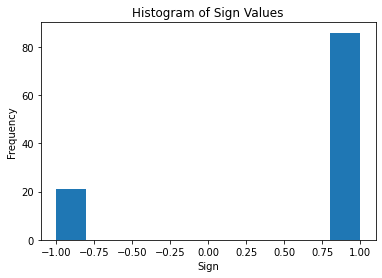

In [56]:
# plt.hist(test_df['sign'])

# # Set the labels and title of the histogram
# plt.xlabel('Sign')
# plt.ylabel('Frequency')
# plt.title('Histogram of Sign Values')

# # Display the histogram
# plt.show()




In [71]:
acc_y = []
f_y = []
for w in [0.1, 0.3, 0.5, 0.7, 0.9, 1]:
    new_test_df = calculateSignPredictions(train_graph, main_clusters, test_df, w)
    confusion_matrix(new_test_df['sign'], new_test_df['sign prediction'])
    acc_temp = accuracy_score(new_test_df['sign'], new_test_df['sign prediction'],  normalize=True, sample_weight=None)
    f_temp = f1_score(new_test_df['sign'], new_test_df['sign prediction'])
    print('acc:', acc_temp, 'f1:', f_temp)
    acc_y.append(acc_temp)
    f_y.append(f_y)

 63%|██████▎   | 67/107 [08:42<01:17,  1.94s/it]<ipython-input-57-6daae620cf7a>:37: RuntimeWarning: invalid value encountered in double_scalars
  result = (np.dot(x.T, r)) / (np.sum(x))
100%|██████████| 107/107 [09:59<00:00,  5.60s/it]


acc: 0.8878504672897196 f1: 0.9325842696629213


 63%|██████▎   | 67/107 [08:30<01:15,  1.88s/it]<ipython-input-57-6daae620cf7a>:37: RuntimeWarning: invalid value encountered in double_scalars
  result = (np.dot(x.T, r)) / (np.sum(x))
100%|██████████| 107/107 [09:45<00:00,  5.47s/it]


acc: 0.8878504672897196 f1: 0.9325842696629213


  2%|▏         | 2/107 [00:41<35:58, 20.55s/it]


KeyboardInterrupt: 